# Data Engineering Pipeline
Data engineering pipelines are commonly comprised of these components:
![title](img/picture.png)

* Ingest Data: Bringing in the data from your source systems; often involving ETL processes (though we will skip this step in this demo for brevity)
* Explore Data: Now that you have cleansed data, explore it so you can get some business insight
* Train ML Model: Execute FP-growth for frequent pattern mining
* Review Association Rules: Review the generated association rules

In [1]:
# import modules
from pyspark.sql import SparkSession

In [2]:
# Local mode
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL instacart example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
spark.version

'2.4.4'

In [4]:
# import the needed librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting

import seaborn as sns
color = sns.color_palette() # Available seaborn palette names:deep, muted, bright, pastel, dark, colorblind
    
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

pd.set_option('display.float_format', lambda x: '%.3f' % x) #Limiting floats output to 3 decimal points

# Ingest Data
[data_description.md](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

### Create DataFrames

In [5]:
aisles = spark.read.csv("aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("orders.csv", header=True, inferSchema=True)
products = spark.read.csv("products.csv", header=True, inferSchema=True)

In [6]:
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

# Exploratory Data Analysis
Explore your Instacart data using Spark SQL

## Busiest day of the week

In [7]:
sqlDF = spark.sql("""
select 
  count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from orders  
 group by order_dow 
 order by total_orders desc""")
sqlDF.show(7)

+------------+-----------+
|total_orders|day_of_week|
+------------+-----------+
|      600905|     Sunday|
|      587478|     Monday|
|      467260|    Tuesday|
|      453368|     Friday|
|      448761|   Saturday|
|      436972|  Wednesday|
|      426339|   Thursday|
+------------+-----------+



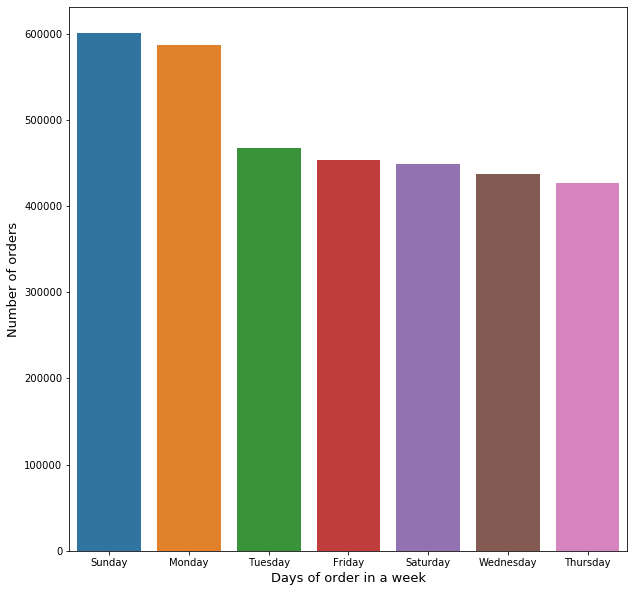

In [9]:
df_pandas = sqlDF.toPandas()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(df_pandas["day_of_week"], df_pandas["total_orders"])
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

In [11]:
sqlDF = spark.sql("""
select 
  count(order_id) as total_orders, 
  order_hour_of_day as hour 
  from orders 
 group by order_hour_of_day 
 order by order_hour_of_day""")
sqlDF.show(7)

+------------+----+
|total_orders|hour|
+------------+----+
|       22758|   0|
|       12398|   1|
|        7539|   2|
|        5474|   3|
|        5527|   4|
|        9569|   5|
|       30529|   6|
|       91868|   7|
|      178201|   8|
|      257812|   9|
|      288418|  10|
|      284728|  11|
|      272841|  12|
|      277999|  13|
|      283042|  14|
|      283639|  15|
|      272553|  16|
|      228795|  17|
|      182912|  18|
|      140569|  19|
+------------+----+
only showing top 20 rows



## Breakdown of Orders by Hour of the Day

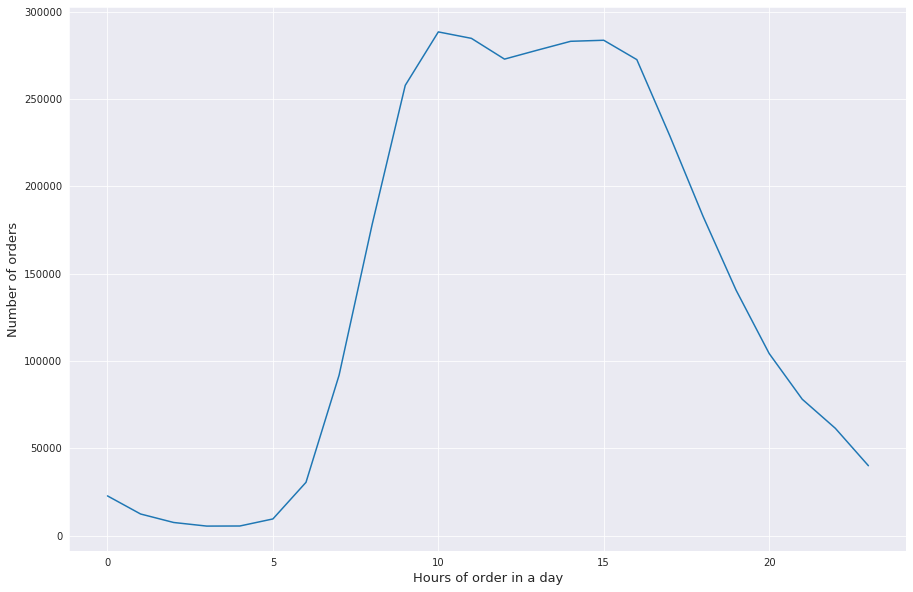

In [24]:
df_pandas = sqlDF.toPandas()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(df_pandas["hour"], df_pandas["total_orders"])
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

## Max Products by Department

In [29]:
sqlDF = spark.sql("""
select countbydept.*
  from (
  -- from product table, let's count number of records per dept
  -- and then sort it by count (highest to lowest) 
  select department_id, count(1) as counter
    from products
   group by department_id
   order by counter asc 
  ) as maxcount
inner join (
  -- let's repeat the exercise, but this time let's join
  -- products and departments tables to get a full list of dept and 
  -- prod count
  select
    d.department_id,
    d.department,
    count(1) as products
    from departments d
      inner join products p
         on p.department_id = d.department_id
   group by d.department_id, d.department 
   order by products desc
  ) countbydept 
  -- combine the two queries's results by matching the product count
  on countbydept.products = maxcount.counter""")
df_pandas = sqlDF.toPandas()

In [32]:
df_pandas.head()

,department_id,department,products
0,11,personal care,6563
1,19,snacks,6264
2,13,pantry,5371
3,7,beverages,4365
4,1,frozen,4007


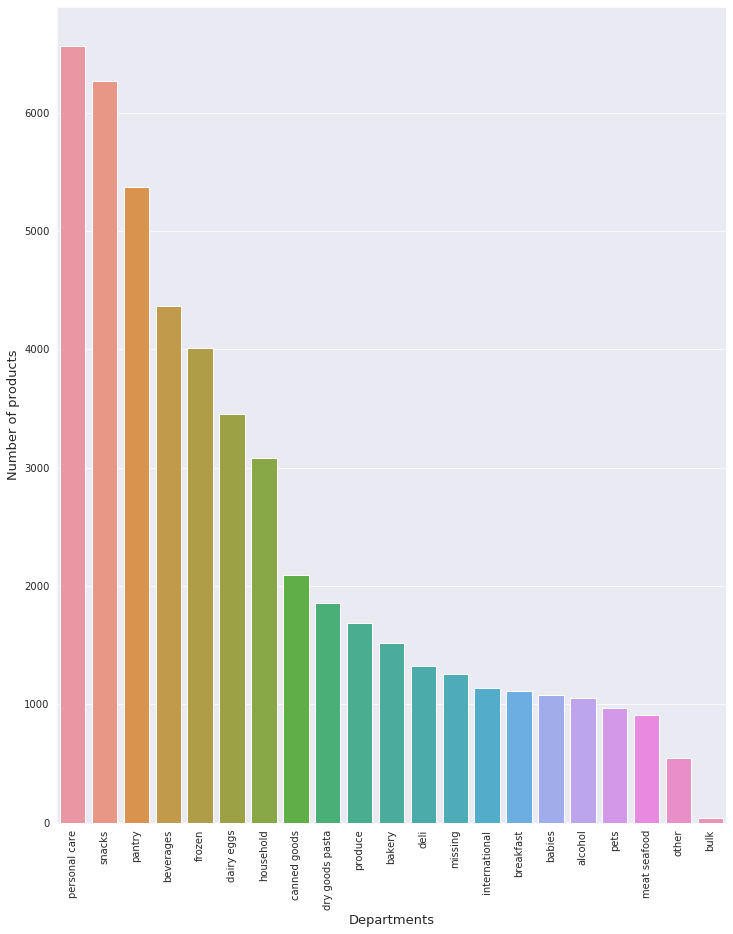

In [31]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(df_pandas["department"],df_pandas["products"])
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

## Top 10 Popular Items

In [33]:
sqlDF = spark.sql("""
select count(opp.order_id) as orders, p.product_name as popular_product
  from order_products_prior opp, products p
 where p.product_id = opp.product_id 
 group by popular_product 
 order by orders desc 
 limit 10""")
df_pandas = sqlDF.toPandas()

In [34]:
df_pandas.head()

,orders,popular_product
0,472565,Banana
1,379450,Bag of Organic Bananas
2,264683,Organic Strawberries
3,241921,Organic Baby Spinach
4,213584,Organic Hass Avocado


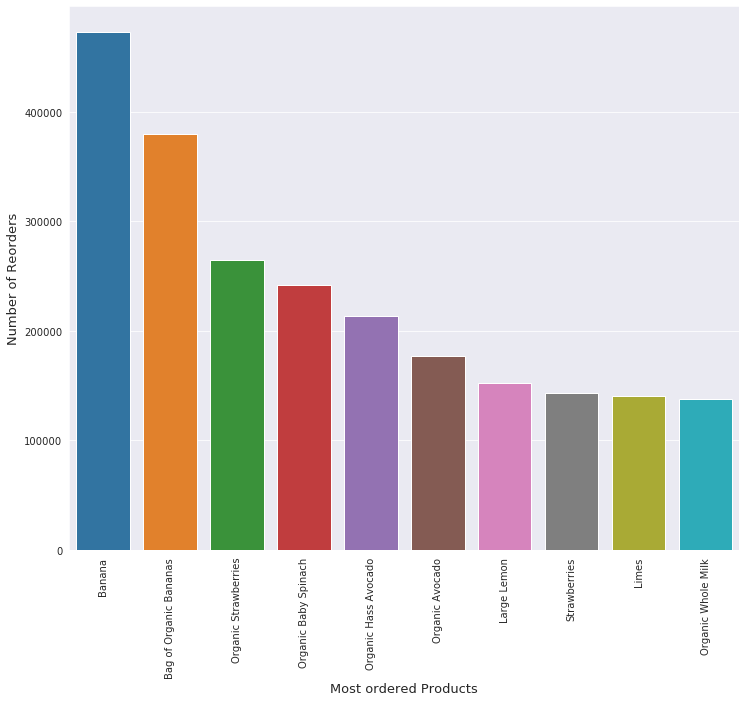

In [35]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(df_pandas["popular_product"], df_pandas["orders"])
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

## Shelf Space by Department

In [36]:
sqlDF = spark.sql("""
select d.department, count(distinct p.product_id) as products
  from products p
    inner join departments d
      on d.department_id = p.department_id
 group by d.department
 order by products desc
 limit 10""")
df_pandas = sqlDF.toPandas()

In [37]:
df_pandas.head()

,department,products
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007


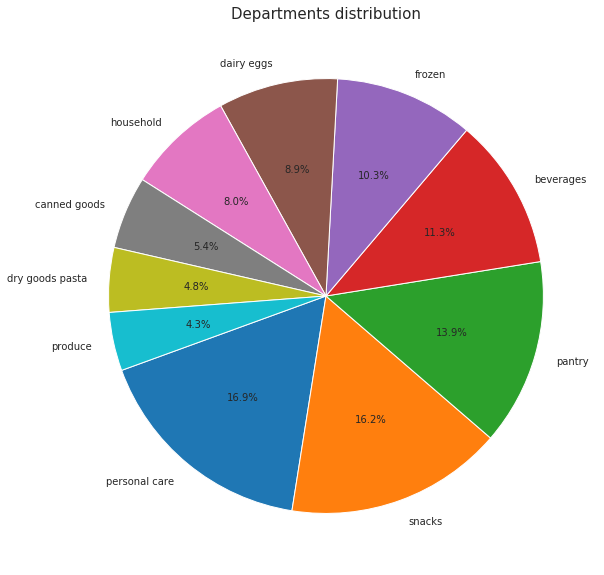

In [38]:
plt.figure(figsize=(10,10))
labels = (np.array(df_pandas['department']))
sizes = (np.array((df_pandas['products'] / df_pandas['products'].sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

## Organize and View Shopping Basket

In [39]:
# Organize the data by shopping basket
from pyspark.sql.functions import collect_set, col, count
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')

## View Shopping Basket

In [41]:
baskets.show(3)

+--------+--------------------+
|order_id|               items|
+--------+--------------------+
|    1342|[Raw Shrimp, Seed...|
|    1591|[Cracked Wheat, S...|
|    4519|[Beet Apple Carro...|
+--------+--------------------+
only showing top 3 rows



# Train ML Model

To understand the frequency of items are associated with each other (e.g. peanut butter and jelly), we will use association rule mining for market basket analysis. [Spark MLlib](http://spark.apache.org/docs/latest/mllib-guide.html) implements two algorithms related to frequency pattern mining (FPM): [FP-growth](https://spark.apache.org/docs/latest/mllib-frequent-pattern-mining.html#fp-growth) and [PrefixSpan](https://spark.apache.org/docs/latest/mllib-frequent-pattern-mining.html#prefixspan). The distinction is that FP-growth does not use order information in the itemsets, if any, while PrefixSpan is designed for sequential pattern mining where the itemsets are ordered. We will use FP-growth as the order information is not important for this use case.

Note, we will be using the ```Scala API``` so we can configure ```setMinConfidence```.